this notebooks shows neuron by neuron comparison of standard data-driven vs. transfer learning.

The hope is to have some picture as in my thesis proposal, showing the potential to combine the two.

in the thesis proposal, data-driven was better; now seems that transfer learning takes over, due to larger data set (not 540-image CRCNS PVC-8 data any more).

SHIT. In the proposal, I suppose I see different neurons getting fitted differently by two methods (low correlation), probably due to fluctuation in the CRCNS PVC-8 data. Here, it seems two methods get quite similar fitting performance (high correlation). Therefore, that "combing two" stuff seems useless.

To completely make sure I failed, I need to

1. wait for ReLU based transfer learning to get a final word on transfer learning.
2. redo these experiments on CRCNS PVC-8 to double check.

In [1]:
from sys import path
from os.path import join

from thesis_v2 import dir_dict

folder_to_check = 'scripts/training/yuanyuan_8k_a_3day'
path.insert(0, join(dir_dict['root'], folder_to_check))
from transfer_learning_factorized_vgg.submit import sparse_list
from transfer_learning_factorized_vgg.key_utils import keygen as keygen_vgg
from maskcnn_polished.key_utils import keygen as keygen_maskcnn

In [2]:
# now let's load vgg's best ones, one for 50x50, one for 100x100.

from thesis_v2.training_extra.transfer_learning.analysis import collect_one_setting

def load_vgg_result(param):
    # vgg11_bn's conv3_1 seems to be the best for 100x100.
    # vgg11_bn's conv2_1 seems to be the best for 50x50.
    # probably this is due to input scaling issue.
    return collect_one_setting(
        sparse_list=sparse_list,
        keygen=keygen_vgg,
        param=param,
    )

vgg_best_50 = load_vgg_result(
{
    'suffix': 'vgg11_bn/quarter/2.0',
    'split_seed': 'legacy',
    'model_seed': 0,
    'act_fn': 'softplus',
    'loss_type': 'poisson',
}
)['test_best']

vgg_best_100 = load_vgg_result(
{
    'suffix': 'vgg11_bn/half/4.0',
    'split_seed': 'legacy',
    'model_seed': 0,
    'act_fn': 'softplus',
    'loss_type': 'poisson',
}
)['test_best']

vgg_best_100_another = load_vgg_result(
{
    'suffix': 'vgg11_bn/half/2.0',
    'split_seed': 'legacy',
    'model_seed': 0,
    'act_fn': 'softplus',
    'loss_type': 'poisson',
}
)['test_best']

In [3]:
vgg_best_50.mean(), vgg_best_100.mean(), vgg_best_100_another.mean()
# match those in the ipynb notebook (`vgg.ipynb`).

(0.5245715360852736, 0.5612101458673235, 0.5558274635408498)

In [4]:
# now let's load maskcnn_polished's best ones, one for 50x50, one for 100x100.

In [5]:
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.data.prepared.yuanyuan_8k import get_data
from thesis_v2.training_extra.data import generate_datasets
from thesis_v2.models.maskcnn_polished.builder import load_modules


from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural

from thesis_v2.training.training import eval_wrapper
from functools import partial
from torchnetjson.builder import build_net
import numpy as np
from torch.backends import cudnn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

load_modules()

def load_maskcnn_result(param):
    # this is tricky, because I did not save per neuron corr during training.
    # shit.
    #
    # afterwards, I will simply save thoese perneuron corr.
    # 
    # right now, let's load the data set and do the evaluation again.
    assert param['out_channel'] == 16
    assert param['num_layer'] == 2
    assert param['kernel_size_l1'] == 9
    assert param['pooling_ksize'] == 3
    assert param['pooling_type'] == 'avg'

    assert param['model_seed'] == 0

    key = keygen_maskcnn(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
    result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
    result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
    
    # then create data set.
    datasets = get_data('a', 200, param['input_size'], ('042318', '043018', '051018'), scale=0.5,
                        seed=param['split_seed'])
    datasets = {
        'X_train': datasets[0].astype(np.float32),
        'y_train': datasets[1],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }
    
    # only the test one is needed.
    datasets = generate_datasets(
        **datasets,
        per_epoch_train=True, shuffle_train=True,
    )['test']
    
    result_on_the_go = eval_wrapper(result['model'].cuda(),
                                    datasets,
                                    'cuda',
                                    1,
                                    partial(eval_fn_wrapper_neural, loss_type=param['loss_type']),
                                        lambda dummy1,dummy2,dummy3: torch.tensor(0.0)
                                   )
    ret = np.asarray(result_on_the_go['corr'])
    print(result_on_the_go['corr_mean'], result['stats_best']['stats']['test']['corr_mean'],
         ret.mean())
    return ret
    

maskcnn_param_template = {
    'out_channel': 16,
    'num_layer': 2,
    'kernel_size_l1': 9,
    'pooling_ksize': 3,
    'pooling_type': 'avg',
    'model_seed': 0,
    'split_seed': 'legacy',
}
maskcnn_best_100 = load_maskcnn_result(
    # 0.537495 in `basic.ipynb`.
    {
        **maskcnn_param_template,
        **{
            'act_fn': 'relu',
            'bn_before_act': True,
            'loss_type': 'mse',
            'smoothness': '0.000005',
            'smoothness_name': '0.000005',
            'scale': '0.01',
            'scale_name': '0.01',
            'bn_after_fc': False,
            'input_size': 100,
        }
    }
)

0.5374951362609863 0.5374951362609863 0.5374951260753825


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(12, 10))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print(xlabel, x.mean(), ylabel, y.mean())
    print('corr', pearsonr(x, y)[0])

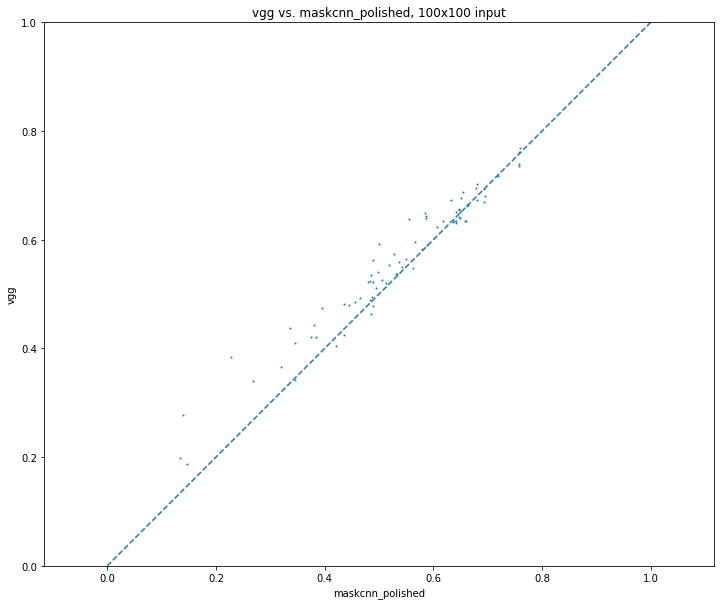

maskcnn_polished 0.5374951260753825 vgg 0.5612101458673235
corr 0.9748182587041524


In [7]:
scatter(maskcnn_best_100, vgg_best_100, 'maskcnn_polished', 'vgg', 'vgg vs. maskcnn_polished, 100x100 input')

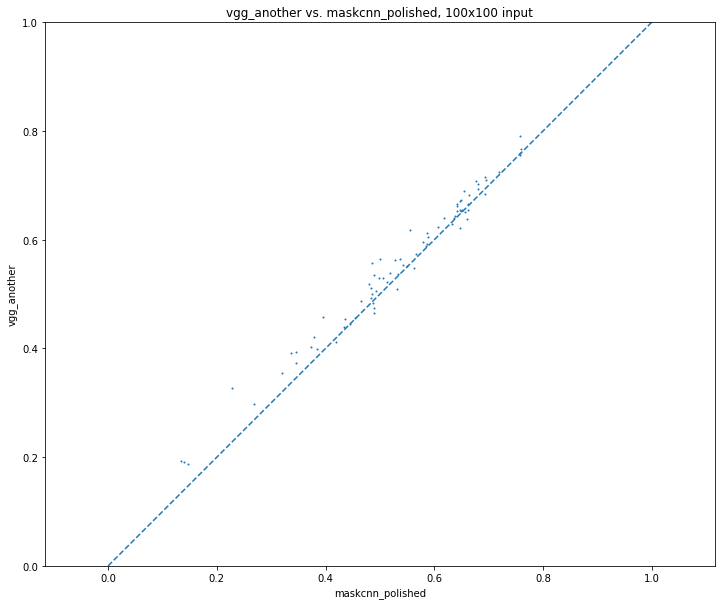

maskcnn_polished 0.5374951260753825 vgg_another 0.5558274635408498
corr 0.988552528763101


In [8]:
scatter(maskcnn_best_100, vgg_best_100_another, 'maskcnn_polished', 'vgg_another', 'vgg_another vs. maskcnn_polished, 100x100 input')

In [9]:
maskcnn_best_50 = load_maskcnn_result(
    # 0.519622 in `basic.ipynb`.
    {
        **maskcnn_param_template,
        **{
            'act_fn': 'relu',
            'bn_before_act': True,
            'loss_type': 'mse',
            'smoothness': '0.000005',
            'smoothness_name': '0.000005',
            'scale': '0.01',
            'scale_name': '0.01',
            'bn_after_fc': False,
            'input_size': 50,
        }
    }
)

0.5196224451065063 0.5196224451065063 0.5196224688729153


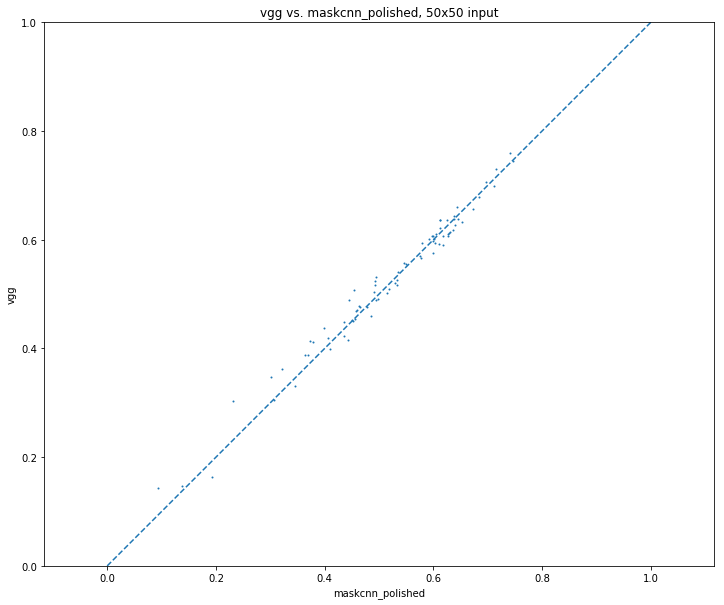

maskcnn_polished 0.5196224688729153 vgg 0.5245715360852736
corr 0.9885017545041239


In [10]:
scatter(maskcnn_best_50, vgg_best_50, 'maskcnn_polished', 'vgg', 'vgg vs. maskcnn_polished, 50x50 input')